In [1]:
import pandas as pd 
import numpy as np 

In [2]:
import pandas as pd
df  = pd.read_csv("D:\personal Projects\classical ML\gr.noida rent prediction (web scrapping)\greater_noida_rents_massive.csv")
df.head()

,BHK,Price,Location,Area,Furnishing,Tenant_Pref,Full_Title,Page_Found
0,2 BHK,"₹17,000 /month",Mahagun Mywoods Phase 1,850 sqft(79 sqm),NaN,Not Specified,"2 BHK Flat for rent in Sector 16C, Greater Noida",1
1,3 BHK,"₹35,000 /month",ACE Divino,"1,565 sqft(145 sqm)",NaN,Not Specified,3 BHK Flat for rent in Noida Extension,1
2,2 BHK,"₹25,000 /month",Ace City,"1,080 sqft(100 sqm)",NaN,Not Specified,2 BHK Flat for rent in Sector 1 Greater Noida ...,1
3,2 BHK,"₹25,000 /month",C block,"1,615 sqft(150 sqm)",Furnished,Not Specified,2 BHK Independent Builder Floor for rent in Si...,1
4,NaN,"₹55,000 /month",Panchsheel Villas,"1,080 sqft(100 sqm)",Furnished,Not Specified,"5 Bedroom House for rent in Sector 16B, Greate...",1


In [3]:
print('Shape of Data:',df.shape)
print('----'*20,'\n Data Types Info:')
print(df.info())

Shape of Data: (2526, 8)
-------------------------------------------------------------------------------- 
 Data Types Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   BHK          2293 non-null   object
 1   Price        2526 non-null   object
 2   Location     2526 non-null   object
 3   Area         2526 non-null   object
 4   Furnishing   735 non-null    object
 5   Tenant_Pref  2526 non-null   object
 6   Full_Title   2526 non-null   object
 7   Page_Found   2526 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 158.0+ KB
None


# Data Cleaning

In [4]:
print(df.isnull().sum())
print('----'*20,'\n Tenent_pref Value Counts:')
print(df['Tenant_Pref'].value_counts())

BHK             233
Price             0
Location          0
Area              0
Furnishing     1791
Tenant_Pref       0
Full_Title        0
Page_Found        0
dtype: int64
-------------------------------------------------------------------------------- 
 Tenent_pref Value Counts:
Tenant_Pref
Not Specified        2471
Family Preferred       39
Bachelors Allowed      10
Family Only             5
Boys Only               1
Name: count, dtype: int64


In [5]:
import re
import pandas as pd

# list of noisy property words that should NOT be treated as a sector/address
property_words = [
    "flat", "flats", "bhk", "bedroom", "bedrooms", "house", "independent",
    "builder floor", "floor", "studio", "apartment", "room", "rooms",
    "for rent", "rent", "sale", "residential", "resale"
]
prop_regex = r"\b(?:" + "|".join(re.escape(w) for w in property_words) + r")\b"

# 1) Primary targeted extraction for known block names / sectors (require number/letter or known word)
pattern_primary = (
    r"(Sector\s*[A-Za-z0-9]+|"
    r"Alpha\s*\w*|Beta\s*\w*|Gamma\s*\w*|Delta\s*\w*|Chi\s*\w*|"
    r"Phi\s*\w*|Omega\s*\w*|Zeta\s*\w*)"
)

df['Sector'] = df['Full_Title'].str.extract(pattern_primary, expand=False)

# 2) Fallback: text after "in " up to comma, parenthesis, or hyphen (most likely contains the address)
fallback = df['Full_Title'].str.extract(r"in\s+([^,()\-\n]+)", expand=False)

# 3) Fill primary NaNs with fallback
df['Sector'] = df['Sector'].fillna(fallback)

# 4) Remove property-type noise from the extracted value
df['Sector'] = (
    df['Sector']
      .astype(str)                                      # safe cast
      .str.replace(prop_regex, "", regex=True, flags=re.IGNORECASE)  # remove property words
      .str.replace(r"\b(Greater Noida|Noida|Noida Extension|Greater Noida West)\b", "", regex=True, case=False)
      .str.replace(r"[,:\-\(\)]", "", regex=True)     # remove punctuation
      .str.strip()
      .replace({"": pd.NA, "nan": pd.NA})             # empty -> NaN
)

# 5) Validation: keep only if it looks like a block/sector/address.
#    We require either:
#      - the word "Sector" OR
#      - a known block name (Alpha/Beta/Chi/...) OR
#      - at least one digit in the result (e.g. "16C", "4", "Block 12")
valid_pattern = re.compile(r"(?i)^(?:.*Sector.*|.*Alpha.*|.*Beta.*|.*Gamma.*|.*Chi.*|.*Delta.*|.*Omega.*|.*Zeta.*|.*\d.*)$")

mask_valid = df['Sector'].notna() & df['Sector'].str.match(valid_pattern)
df.loc[~mask_valid, 'Sector'] = pd.NA

# 6) Optional: tidy casing and normalize "sector" words
df['Sector'] = df['Sector'].str.replace(r"^sector\s+", "Sector ", flags=re.IGNORECASE, regex=True)
df['Sector'] = df['Sector'].str.title()

# Quick checks
print("Remaining NaNs in Sector:", df['Sector'].isnull().sum())
print("Sample extracted values (non-null):")
print(df['Sector'].dropna().unique()[:50])


Remaining NaNs in Sector: 341
Sample extracted values (non-null):
['Sector 16C' 'Sector 1' 'Sigma 4' 'Sector 16B' 'Sector 10'
 'Techzone 4  West' 'Sector 27' 'Sector Zeta' 'Sector 16' 'Sector Chi'
 'Sector 4' 'Sector' 'Sector Pi' 'Sector 2' 'Sector Xu' 'Sector P4'
 'Sector 31' 'Sector Omicron' 'Techzone 4' 'Eta 2' 'Nh 91' 'Sector Mu'
 'Delta 1' 'Sector 3' 'Alpha 2' 'Sector Phi' 'Sector 22D' 'Gamma 2'
 'Beta 1' 'Ecotech 3' 'Knowledge Park 3' 'Delta I' 'Sector P3' 'Sigma 2'
 'Site 5' 'Beta 2' 'Rho 1 Sector' 'Sector 25' 'Ecotech 1 Extension'
 'Chi Phi' 'Sigma 1' 'Delta 3' 'Sector Omega' 'Alpha 1' 'Gamma 1']


In [6]:
df.isnull().sum()

BHK             233
Price             0
Location          0
Area              0
Furnishing     1791
Tenant_Pref       0
Full_Title        0
Page_Found        0
Sector          341
dtype: int64

In [7]:
df.dropna(subset=['Sector'], inplace=True)
df.dropna(subset=['BHK'], inplace=True)
df.isnull().sum()

BHK               0
Price             0
Location          0
Area              0
Furnishing     1529
Tenant_Pref       0
Full_Title        0
Page_Found        0
Sector            0
dtype: int64

In [8]:
df.head()


,BHK,Price,Location,Area,Furnishing,Tenant_Pref,Full_Title,Page_Found,Sector
0,2 BHK,"₹17,000 /month",Mahagun Mywoods Phase 1,850 sqft(79 sqm),NaN,Not Specified,"2 BHK Flat for rent in Sector 16C, Greater Noida",1,Sector 16C
2,2 BHK,"₹25,000 /month",Ace City,"1,080 sqft(100 sqm)",NaN,Not Specified,2 BHK Flat for rent in Sector 1 Greater Noida ...,1,Sector 1
3,2 BHK,"₹25,000 /month",C block,"1,615 sqft(150 sqm)",Furnished,Not Specified,2 BHK Independent Builder Floor for rent in Si...,1,Sigma 4
5,3 BHK,"₹21,000 /month",Arihant Abode,"1,160 sqft(108 sqm)",NaN,Not Specified,3 BHK Flat for rent in Sector 10 Greater Noida...,1,Sector 10
6,4 BHK,"₹26,000 /month",La Residentia,"1,538 sqft(143 sqm)",Semi-Furnished,Not Specified,4 BHK Flat for rent in Techzone 4 Greater Noid...,1,Techzone 4 West


In [9]:
cols_to_drop = [
    'Location',
    'Furnishing',
    'Tenant_Pref',
    'Full_Title',
    'Page_Found'
]

df = df.drop(columns=cols_to_drop, errors='ignore')
df.head()

,BHK,Price,Area,Sector
0,2 BHK,"₹17,000 /month",850 sqft(79 sqm),Sector 16C
2,2 BHK,"₹25,000 /month","1,080 sqft(100 sqm)",Sector 1
3,2 BHK,"₹25,000 /month","1,615 sqft(150 sqm)",Sigma 4
5,3 BHK,"₹21,000 /month","1,160 sqft(108 sqm)",Sector 10
6,4 BHK,"₹26,000 /month","1,538 sqft(143 sqm)",Techzone 4 West


In [10]:
# Changing BHK col into int
df['BHK'] = df['BHK'].str.extract(r'(\d+)').astype(int)

#changing Price Col into Int
df['Price (Rupee)'] = (
    df['Price']
    .str.replace('₹', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.extract(r'(\d+)')[0]
    .astype(int)
)
# changing Area col into int
# FIX for Cell 10
# Remove commas first, then extract
df['Area_sqft'] = df['Area'].str.replace(',', '').str.extract(r'(\d+)\s*sqft')[0].astype(int)

#dropping original cols
cols_to_drop2 = [
    'Price',
    'Area'   
]
# dropping original cols
df = df.drop(columns=cols_to_drop2, errors='ignore')
df.head()


,BHK,Sector,Price (Rupee),Area_sqft
0,2,Sector 16C,17000,850
2,2,Sector 1,25000,1080
3,2,Sigma 4,25000,1615
5,3,Sector 10,21000,1160
6,4,Techzone 4 West,26000,1538


In [11]:
print(df.info())
print('---'*20,)
print('\n count of catagory in Sector Column is' , len(df['Sector'].unique()))

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, 0 to 2525
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   BHK            2007 non-null   int32 
 1   Sector         2007 non-null   object
 2   Price (Rupee)  2007 non-null   int32 
 3   Area_sqft      2007 non-null   int32 
dtypes: int32(3), object(1)
memory usage: 54.9+ KB
None
------------------------------------------------------------

 count of catagory in Sector Column is 32


In [12]:
df['Sector'].unique()

array(['Sector 16C', 'Sector 1', 'Sigma 4', 'Sector 10',
       'Techzone 4  West', 'Sector 27', 'Sector 16', 'Sector Zeta',
       'Sector 16B', 'Sector Chi', 'Sector 4', 'Sector', 'Sector Pi',
       'Sector 2', 'Sector Xu', 'Sector P4', 'Sector 31',
       'Sector Omicron', 'Techzone 4', 'Eta 2', 'Sector Mu', 'Sector 3',
       'Alpha 2', 'Sector Phi', 'Ecotech 3', 'Gamma 2', 'Sector 22D',
       'Sigma 2', 'Beta 1', 'Beta 2', 'Rho 1 Sector', 'Sector 25'],
      dtype=object)

# Feature Engreening

In [13]:
# Creating a new feature Area per BHK
df['Area_Per_BHK'] = df['Area_sqft'] / df['BHK']

# Log Transformation of Price for better distribution
df['log_Price'] = np.log1p(df['Price (Rupee)'])

df.head()

,BHK,Sector,Price (Rupee),Area_sqft,Area_Per_BHK,log_Price
0,2,Sector 16C,17000,850,425.000000,9.741027
2,2,Sector 1,25000,1080,540.000000,10.126671
3,2,Sigma 4,25000,1615,807.500000,10.126671
5,3,Sector 10,21000,1160,386.666667,9.952325
6,4,Techzone 4 West,26000,1538,384.500000,10.165890


Dealing with outliers

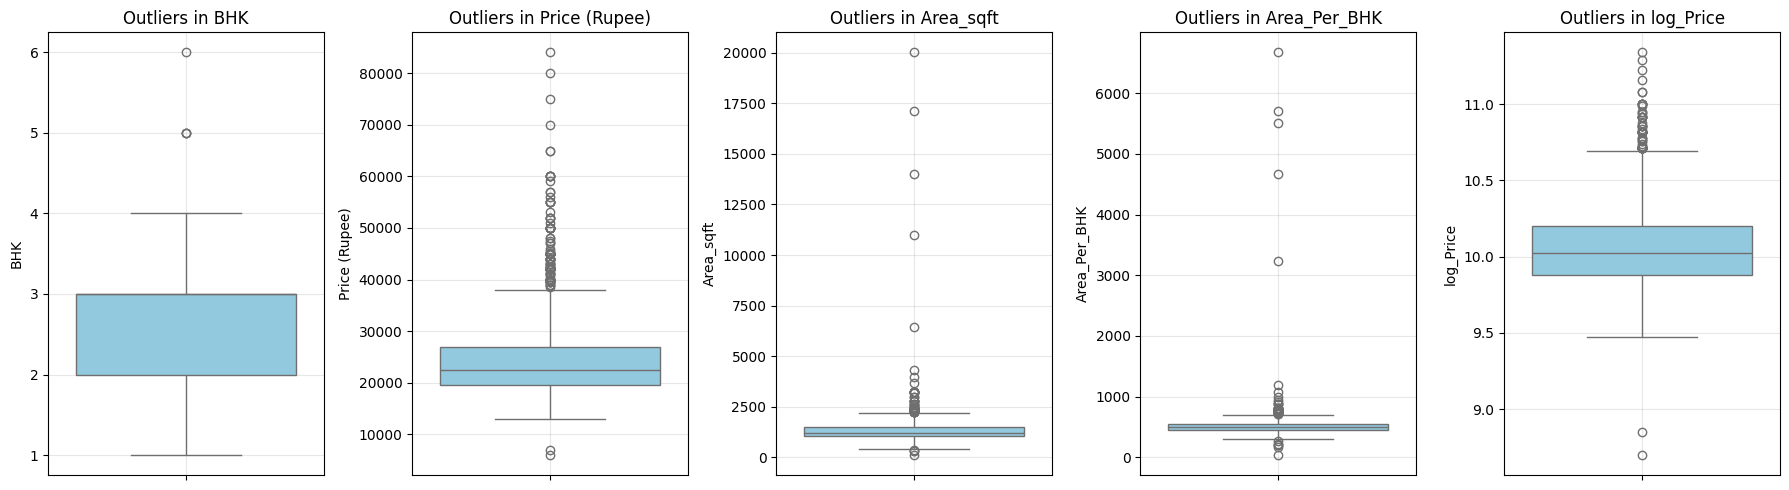

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select the columns you want to check
numerical_cols = ['BHK', 'Price (Rupee)', 'Area_sqft', 'Area_Per_BHK', 'log_Price']

# --- VISUALIZATION 1: BOX PLOTS (To see the range of outliers) ---
plt.figure(figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Outliers in {col}', fontsize=12)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



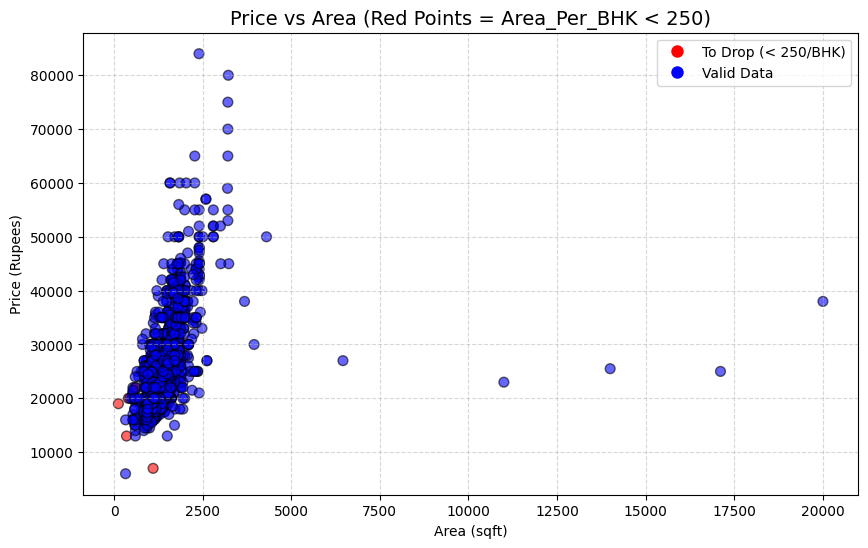

Sample of rows to be dropped:
      BHK  Area_sqft  Price (Rupee)
960     2        400          20000
1020    5       1100           7000
1032    2        350          13000
1690    3        615          22000
2217    3        120          19000


In [15]:
# --- VISUALIZATION 2: WHAT ARE YOU DROPPING? ---
# This highlights the rows with Area_Per_BHK < 250 in RED
plt.figure(figsize=(10, 6))

# Create a color mask: Red for "To Drop", Blue for "Keep"
colors = df['Area_Per_BHK'].apply(lambda x: 'red' if x < 250 else 'blue')

plt.scatter(df['Area_sqft'], df['Price (Rupee)'], c=colors, alpha=0.6, edgecolors='k', s=50)
plt.title('Price vs Area (Red Points = Area_Per_BHK < 250)', fontsize=14)
plt.xlabel('Area (sqft)')
plt.ylabel('Price (Rupees)')
plt.grid(True, linestyle='--', alpha=0.5)

# Add a dummy legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='To Drop (< 250/BHK)', markersize=10),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Valid Data', markersize=10)]
plt.legend(handles=legend_elements)

plt.show()

# --- CHECK 3: PRINT THE DATA ---
print("Sample of rows to be dropped:")
print(df[df['Area_Per_BHK'] < 250][[ 'BHK', 'Area_sqft', 'Price (Rupee)']].head(10))

In [16]:
df[df['Area_Per_BHK'] < 250]

,BHK,Sector,Price (Rupee),Area_sqft,Area_Per_BHK,log_Price
960,2,Sector Chi,20000,400,200.0,9.903538
1020,5,Ecotech 3,7000,1100,220.0,8.853808
1032,2,Sector 1,13000,350,175.0,9.472782
1690,3,Sector 4,22000,615,205.0,9.998843
2217,3,Sector 4,19000,120,40.0,9.852247


In [17]:
df[df['Area_sqft'] > 2400]

,BHK,Sector,Price (Rupee),Area_sqft,Area_Per_BHK,log_Price
32,4,Techzone 4 West,57000,2590,647.500000,10.950824
36,5,Sector Zeta,52000,2800,560.000000,10.859018
57,4,Techzone 4 West,57000,2590,647.500000,10.950824
61,5,Sector Zeta,52000,2800,560.000000,10.859018
129,4,Sector Zeta,50000,2800,700.000000,10.819798
192,4,Sector 16,33000,2480,620.000000,10.404293
235,4,Sector 10,45000,3235,808.750000,10.714440
441,3,Sector 1,25500,14000,4666.666667,10.146473
481,3,Sector 31,36000,2433,811.000000,10.491302
604,4,Sector 16,40000,2480,620.000000,10.596660


In [18]:
df_clean = df[(df['Area_Per_BHK'] >= 250) & (df['Area_sqft'] <= 2400)].copy()

In [19]:
print(f"Original Shape: {df.shape}")
print(f"Cleaned Shape:  {df_clean.shape}")
print(f"Dropped Rows:   {df.shape[0] - df_clean.shape[0]}")

Original Shape: (2007, 6)
Cleaned Shape:  (1971, 6)
Dropped Rows:   36


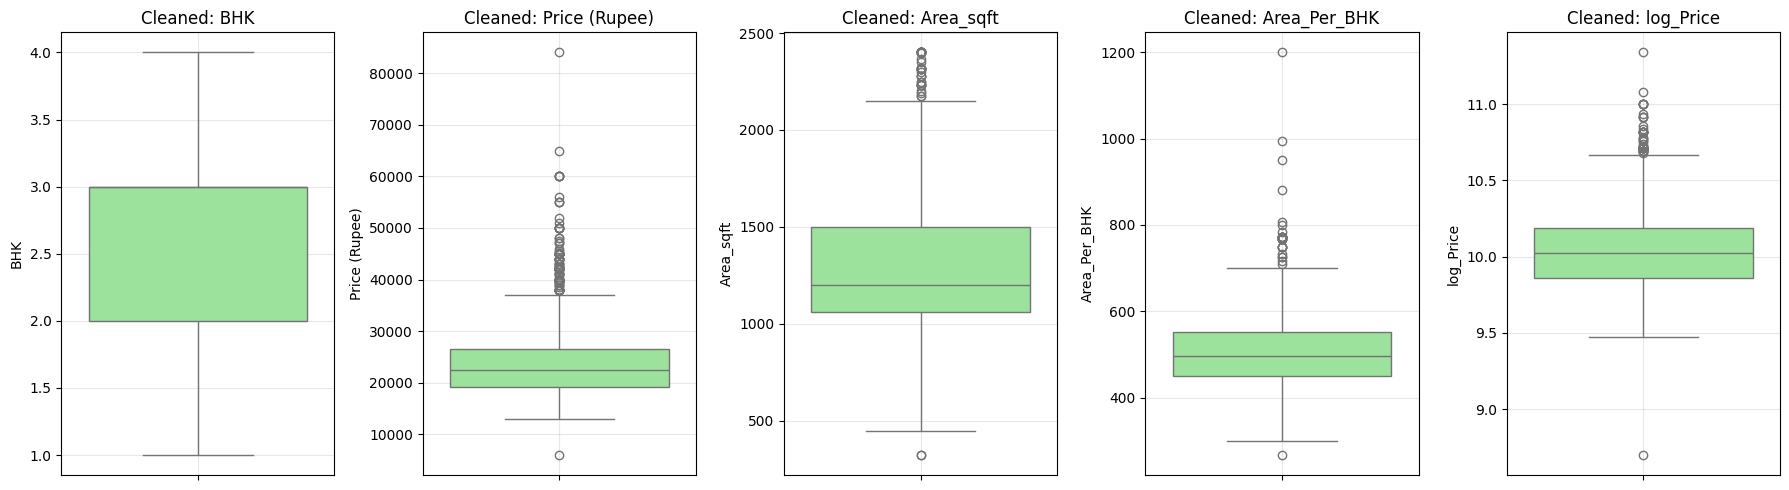

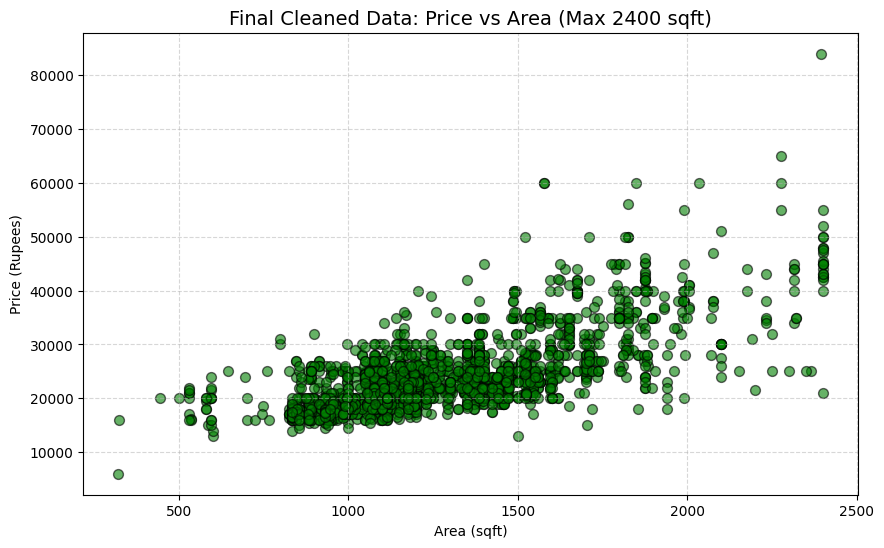

In [20]:
numerical_cols = ['BHK', 'Price (Rupee)', 'Area_sqft', 'Area_Per_BHK', 'log_Price']

# A. Boxplots (To check if outliers are gone)
plt.figure(figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 5, i+1)
    # Using 'green' to indicate this is the clean/good data
    sns.boxplot(y=df_clean[col], color='lightgreen')
    plt.title(f'Cleaned: {col}', fontsize=12)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# B. Scatter Plot (The Final Sanity Check)
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Area_sqft'], df_clean['Price (Rupee)'], alpha=0.6, c='green', edgecolors='k', s=50)
plt.title('Final Cleaned Data: Price vs Area (Max 2400 sqft)', fontsize=14)
plt.xlabel('Area (sqft)')
plt.ylabel('Price (Rupees)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [21]:
df_clean.head() 

,BHK,Sector,Price (Rupee),Area_sqft,Area_Per_BHK,log_Price
0,2,Sector 16C,17000,850,425.000000,9.741027
2,2,Sector 1,25000,1080,540.000000,10.126671
3,2,Sigma 4,25000,1615,807.500000,10.126671
5,3,Sector 10,21000,1160,386.666667,9.952325
6,4,Techzone 4 West,26000,1538,384.500000,10.165890


Splitting Data 

In [22]:
from sklearn.model_selection import train_test_split

# 1. Setup Data
# We use log_Price for training to get better accuracy
X = df_clean[['BHK', 'Area_sqft', 'Sector', 'Area_Per_BHK']]
y = df_clean['log_Price']

# 2. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Target and rank Encoding for 'Sector

In [23]:
# 1. Calculate Average Price per Sector (using ONLY Train data to avoid leakage)
sector_means = y_train.groupby(X_train['Sector']).mean()


# Map the mean prices to X_train and X_test
X_train['Sector_Price'] = X_train['Sector'].map(sector_means)
X_test['Sector_Price'] = X_test['Sector'].map(sector_means)

# Fill missing sectors (if any) with the global average of y_train
global_mean = y_train.mean()
X_train['Sector_Price'] = X_train['Sector_Price'].fillna(global_mean)
X_test['Sector_Price'] = X_test['Sector_Price'].fillna(global_mean)


# Sort the sectors by price and assign ranks (1 = Cheapest, 32 = Most Expensive)
# We convert the sorted series to a rank dictionary
sector_ranks = sector_means.sort_values().rank(method='first').astype(int).to_dict()

# Map the ranks to X_train and X_test
X_train['Sector_Rank'] = X_train['Sector'].map(sector_ranks)
X_test['Sector_Rank'] = X_test['Sector'].map(sector_ranks)

# Fill missing sectors in Test with the median rank (safer than 0 for tree models)
median_rank = int(len(sector_ranks) / 2)
X_test['Sector_Rank'] = X_test['Sector_Rank'].fillna(median_rank)

# 4. Drop the Original Text Column
X_train = X_train.drop('Sector', axis=1)
X_test = X_test.drop('Sector', axis=1)

print("Training Data Ready. Shape:", X_train.shape)
print("Features included:", X_train.columns.tolist())

Training Data Ready. Shape: (1576, 5)
Features included: ['BHK', 'Area_sqft', 'Area_Per_BHK', 'Sector_Price', 'Sector_Rank']


In [24]:
X_train.head()

,BHK,Area_sqft,Area_Per_BHK,Sector_Price,Sector_Rank
686,3,1425,475.000000,9.911386,8
1059,3,2152,717.333333,10.126671,20
2137,4,2100,525.000000,10.127170,22
1176,3,1440,480.000000,9.911386,8
1096,2,900,450.000000,10.070503,14
